In [6]:
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import tifffile

In [7]:
import os
from glob import glob

image_dir = '/kaggle/input/satelliteimages/data/images'
mask_dir = '/kaggle/input/satelliteimages/data/labels'

image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))

# Extract image filenames without extensions
image_filenames = [os.path.basename(path).split('.')[0] for path in image_paths]

# Filter mask paths to only include masks that have a corresponding image
filtered_mask_paths = [mask_path for mask_path in mask_paths if os.path.basename(mask_path).split('.')[0] in image_filenames]

print("Filtered Image Paths:", len(image_paths))
print("Filtered Mask Paths:", len(filtered_mask_paths))

# Now you should be able to do train_test_split without the ValueError
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, filtered_mask_paths, test_size=0.15, random_state=42)

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    train_image_paths, train_mask_paths, test_size=0.21, random_state=42)

batch_size = 16


Filtered Image Paths: 306
Filtered Mask Paths: 306


In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = self.load_image(self.image_paths[idx])
        mask = self.load_mask(self.mask_paths[idx])
        
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return image, mask

    def load_image(self, image_path):
        image = np.array(tifffile.imread(image_path), dtype=np.float32)
        image = self.normalize_image(image)
        image = torch.tensor(image).float().permute(2, 0, 1)  # Convert HWC to CHW
        return image
    
    def load_mask(self, mask_path):
        mask = Image.open(mask_path).convert('L')
        mask = np.expand_dims(mask, axis=-1).astype(np.float32)
        mask = torch.tensor(mask).float().permute(2, 0, 1)  # Convert HWC to CHW
        return mask

    def normalize_image(self, image):
        normalized_image = np.zeros([128,128,12])
        for j in range(12):
            min_val = np.min(image[:,:,j])
            max_val = np.max(image[:,:,j])
            normalized_image[:,:,j] = (image[:,:,j] - min_val) / (max_val - min_val + 1e-6)
        return normalized_image
    
class RandomHorizontalFlip:
    def __call__(self, image, mask):
        if torch.rand(1) < 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)
        return image, mask

class RandomVerticalFlip:
    def __call__(self, image, mask):
        if torch.rand(1) < 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)
        return image, mask

class RandomBrightness:
    def __call__(self, image):
        image_np = image.numpy().astype(np.float32)
        brightness_factor = np.random.uniform(0.8, 1.2)
        image_np = np.clip(image_np * brightness_factor, 0, 1)
        return image

class RandomContrast:
    def __call__(self, image):
        image_np = image.numpy().astype(np.float32)
        mean = np.mean(image_np, axis=(1, 2), keepdims=True)
        contrast_factor = np.random.uniform(0.8, 1.2)
        image_np = np.clip((image_np - mean) * contrast_factor + mean, 0, 1)
        return image
    
class ToTensorAndAugment:
    def __init__(self):
        self.horizontal_flip = RandomHorizontalFlip()
        self.vertical_flip = RandomVerticalFlip()
        self.brightness = RandomBrightness()
        self.contrast = RandomContrast()

    def __call__(self, image, mask):
        image, mask = self.horizontal_flip(image, mask)
        image, mask = self.vertical_flip(image, mask)
        image = self.brightness(image)
        image = self.contrast(image)
        
        #image = torch.tensor(image).float()
        image = image.clone().detach()
        #mask = torch.tensor(mask).float()
        mask = mask.clone().detach()
        
        return image, mask
    
train_dataset = SatelliteDataset(train_image_paths, train_mask_paths, transform=ToTensorAndAugment())
val_dataset = SatelliteDataset(val_image_paths, val_mask_paths)
test_dataset = SatelliteDataset(test_image_paths, test_mask_paths)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [9]:
channel_names = ['Coastal aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA BAND', 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurrence probability']

first_image_shape = None
consistent_shape = True

batch_images, batch_masks = next(iter(test_loader))
ind = np.random.randint(low=0, high=batch_images.shape[0])
display = batch_images[ind]
disp_mask = batch_masks[ind]
for i in range(len(batch_images)):
    if first_image_shape is None:
        first_image_shape = batch_images[i].shape
    else:
        if batch_images[i].shape != first_image_shape:
            print(f"Mismatch found: {batch_images[i].shape} != {first_image_shape}")
            consistent_shape = False
            break
print("Shape of batch_images:", batch_images.shape, "and len: ", len(batch_images))
print("Shape of batch_masks:", batch_masks.shape)
if consistent_shape:
    print(f"All images have the same shape: {first_image_shape}")
    input_shape = first_image_shape
else:
    print("Not all images have the same shape.")

Shape of batch_images: torch.Size([16, 12, 128, 128]) and len:  16
Shape of batch_masks: torch.Size([16, 1, 128, 128])
All images have the same shape: torch.Size([12, 128, 128])


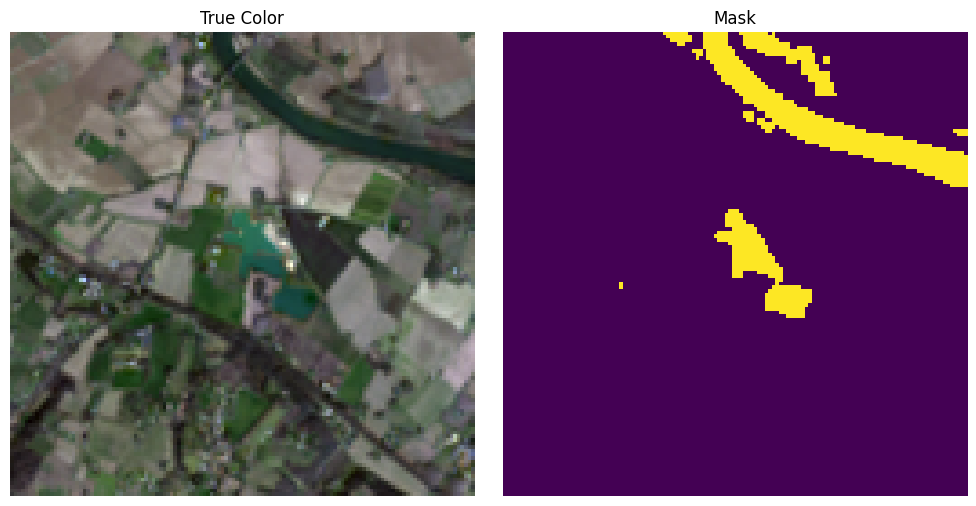

In [11]:
import matplotlib.pyplot as plt
true_color = np.stack([display[channel_names.index('Red')],
                       display[channel_names.index('Green')],
                       display[channel_names.index('Blue')]], axis=-1)

# Visualizing only "True Color" and "Ground Truth Mask"
vis = {
    "True Color": true_color,
    "Mask": disp_mask[0]
}

# Create a figure with 1 row and 2 columns (since we have 2 images to display)
plt.figure(figsize=(10, 5))  # Adjust the size as needed
index = 1
for name in vis:
    ax = plt.subplot(1, 2, index)  # 1 row, 2 columns
    plt.imshow(vis[name])
    plt.title(name)
    plt.axis("off")
    index += 1

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()


In [12]:
import torchvision.models.segmentation as segmentation
class DeepLab(nn.Module):
    def __init__(self):
        super(DeepLab, self).__init__()
        self.model = segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
        
        self.model.backbone.conv1 = nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        self.model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1))

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.backbone.conv1.parameters():
            param.requires_grad = True
        for param in self.model.classifier[4].parameters():
            param.requires_grad = True

    def forward(self, x):
        output = self.model(x)['out']
        output = torch.sigmoid(output)
        return output
    
    def unfreeze_classifier(self):
        for param in self.model.classifier.parameters():
            param.requires_grad = True

    def unfreeze_all(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [14]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.4 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=3644e44102a456943adb8a15e0bc02512d3e8fa7c8d941cdbc2a2c574ecc175f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=41443e0994dab9d6a965e3f37d05f8daba4ec6e98b1441294c10b8c6f7a8824c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [15]:
from segmentation_models_pytorch import Unet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.model = Unet(
            encoder_name='resnet34', 
            encoder_weights='imagenet', 
            in_channels=12,
            classes=1,
        )
        
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.encoder.conv1.parameters():
            param.requires_grad = True

    def forward(self, x):
        output = self.model(x)
        return torch.sigmoid(output)

    def unfreeze_classifier(self):
        for param in self.model.segmentation_head.parameters():
            param.requires_grad = True

    def unfreeze_all(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [16]:
import torch.nn.functional as F
    
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):

        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        F_loss = F_loss.mean()

        inputs = inputs.squeeze(1)
        targets = targets.float().squeeze(1)

        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice = 1 - dice
        return F_loss + dice
    
class BCE(nn.Module):
    def __init__(self, reduction='mean'):
        super(BCE, self).__init__()
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction=self.reduction)
        return BCE_loss
    
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_iou(preds, targets):
    intersection = ((preds == 1) & (targets == 1)).sum().item()
    union = ((preds == 1) | (targets == 1)).sum().item()
    iou = intersection / (union + 1e-6)
    return iou

In [17]:
import torch.optim as optim
from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
print(summary(model, input_size=(batch_size, 12, 128, 128)))

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=4e-3, weight_decay=2e-4)  #to be adjusted
criterion = CombinedLoss()

def train_or_evaluate(model, dataloader, optimizer=optimizer, loss_fn=criterion, device=device, mode='train'):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    
    total_loss = 0.0
    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_f1s = []
    all_ious = []
    
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        
        if mode == 'train':
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                outputs = model(images)
                loss = loss_fn(outputs, masks)
        
        total_loss += loss.item()

        preds = (outputs > 0.5).float()

        accuracy = accuracy_score(masks.view(-1).cpu().numpy(), preds.view(-1).cpu().numpy())
        precision = precision_score(masks.view(-1).cpu().numpy(), preds.view(-1).cpu().numpy(), average='weighted')
        recall = recall_score(masks.view(-1).cpu().numpy(), preds.view(-1).cpu().numpy(), average='weighted')
        f1 = f1_score(masks.view(-1).cpu().numpy(), preds.view(-1).cpu().numpy(), average='weighted')
        iou = calculate_iou(preds, masks)
        
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
        all_ious.append(iou)
    
    average_loss = total_loss / len(dataloader)
    average_accuracy = sum(all_accuracies) / len(all_accuracies) if all_accuracies else 0.0
    average_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0.0
    average_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0.0
    average_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0.0
    average_iou = sum(all_ious) / len(all_ious) if all_ious else 0.0
    
    return average_loss, average_accuracy, average_precision, average_recall, average_f1, average_iou

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 249MB/s] 


Layer (type:depth-idx)                             Output Shape              Param #
UNet                                               [16, 1, 128, 128]         --
├─Unet: 1-1                                        [16, 1, 128, 128]         --
│    └─ResNetEncoder: 2-1                          [16, 12, 128, 128]        --
│    │    └─Conv2d: 3-1                            [16, 64, 64, 64]          37,632
│    │    └─BatchNorm2d: 3-2                       [16, 64, 64, 64]          (128)
│    │    └─ReLU: 3-3                              [16, 64, 64, 64]          --
│    │    └─MaxPool2d: 3-4                         [16, 64, 32, 32]          --
│    │    └─Sequential: 3-5                        [16, 64, 32, 32]          (221,952)
│    │    └─Sequential: 3-6                        [16, 128, 16, 16]         (1,116,416)
│    │    └─Sequential: 3-7                        [16, 256, 8, 8]           (6,822,400)
│    │    └─Sequential: 3-8                        [16, 512, 4, 4]           (13,11

In [18]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []
train_ious, val_ious = [], []

model.unfreeze_classifier()
num_epochs1 = 60
count = 0

for epoch in range(num_epochs1):
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_iou = train_or_evaluate(model, train_loader, mode='train')
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_iou = train_or_evaluate(model, val_loader, mode='eval')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    count += 1
    print(f'Epoch {epoch+1}/{num_epochs1}')
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}')

Epoch 1/60
Train Loss: 0.6865, Accuracy: 0.7082, Precision: 0.6970, Recall: 0.7082, F1: 0.6975, IoU: 0.2435
Val Loss: 0.6642, Accuracy: 0.7026, Precision: 0.7019, Recall: 0.7026, F1: 0.6879, IoU: 0.2648
Epoch 2/60
Train Loss: 0.6595, Accuracy: 0.7443, Precision: 0.7363, Recall: 0.7443, F1: 0.7340, IoU: 0.2976
Val Loss: 0.6447, Accuracy: 0.7255, Precision: 0.7288, Recall: 0.7255, F1: 0.7106, IoU: 0.2991
Epoch 3/60
Train Loss: 0.6546, Accuracy: 0.7527, Precision: 0.7458, Recall: 0.7527, F1: 0.7432, IoU: 0.3091
Val Loss: 0.6454, Accuracy: 0.7234, Precision: 0.7261, Recall: 0.7234, F1: 0.7089, IoU: 0.2994
Epoch 4/60
Train Loss: 0.6548, Accuracy: 0.7531, Precision: 0.7524, Recall: 0.7531, F1: 0.7440, IoU: 0.3106
Val Loss: 0.6380, Accuracy: 0.7339, Precision: 0.7380, Recall: 0.7339, F1: 0.7201, IoU: 0.3174
Epoch 5/60
Train Loss: 0.6466, Accuracy: 0.7632, Precision: 0.7611, Recall: 0.7632, F1: 0.7541, IoU: 0.3269
Val Loss: 0.6341, Accuracy: 0.7362, Precision: 0.7400, Recall: 0.7362, F1: 0.722

In [19]:
model.unfreeze_all()
num_epochs2 = 80
optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=3e-4)  #to be adjusted

for epoch in range(num_epochs2):
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_iou = train_or_evaluate(model, train_loader, optimizer=optimizer, mode='train')
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_iou = train_or_evaluate(model, val_loader, mode='eval')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    count += 1
    print(f'Epoch {epoch+1}/{num_epochs2}')
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f}')

Epoch 1/80
Train Loss: 0.4148, Accuracy: 0.8589, Precision: 0.8646, Recall: 0.8589, F1: 0.8588, IoU: 0.5853
Val Loss: 0.3559, Accuracy: 0.8699, Precision: 0.8842, Recall: 0.8699, F1: 0.8671, IoU: 0.6185
Epoch 2/80
Train Loss: 0.3444, Accuracy: 0.8821, Precision: 0.8868, Recall: 0.8821, F1: 0.8804, IoU: 0.6190
Val Loss: 0.3415, Accuracy: 0.8783, Precision: 0.8949, Recall: 0.8783, F1: 0.8715, IoU: 0.6222
Epoch 3/80
Train Loss: 0.3397, Accuracy: 0.8851, Precision: 0.8885, Recall: 0.8851, F1: 0.8813, IoU: 0.6151
Val Loss: 0.3418, Accuracy: 0.8699, Precision: 0.8878, Recall: 0.8699, F1: 0.8711, IoU: 0.6220
Epoch 4/80
Train Loss: 0.3253, Accuracy: 0.8886, Precision: 0.8910, Recall: 0.8886, F1: 0.8863, IoU: 0.6301
Val Loss: 0.3019, Accuracy: 0.8927, Precision: 0.9037, Recall: 0.8927, F1: 0.8927, IoU: 0.6665
Epoch 5/80
Train Loss: 0.3450, Accuracy: 0.8749, Precision: 0.8852, Recall: 0.8749, F1: 0.8757, IoU: 0.6106
Val Loss: 0.3328, Accuracy: 0.8928, Precision: 0.9037, Recall: 0.8928, F1: 0.889

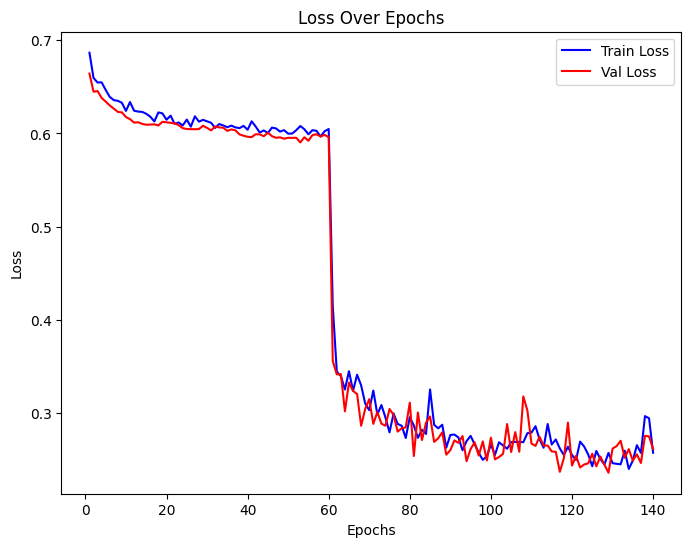

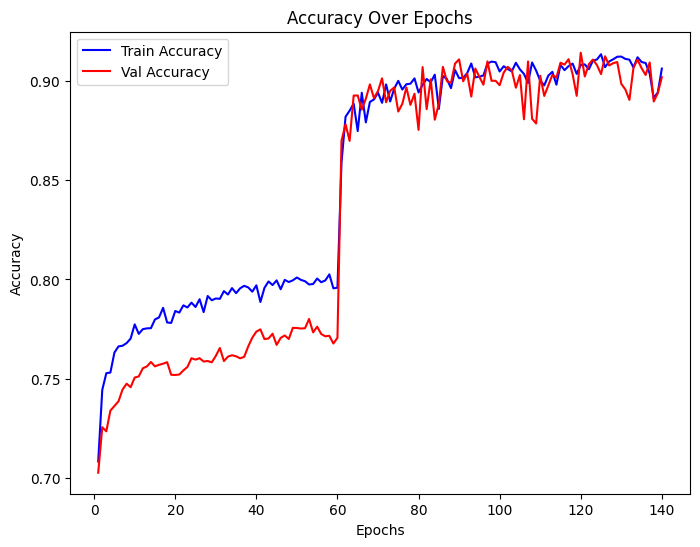

In [20]:
import matplotlib.pyplot as plt

# Assuming variables like `train_losses`, `val_losses`, `train_accuracies`, and `val_accuracies` are already defined

# Number of epochs
epochs = range(1, count + 1)

# Plotting Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [22]:
criteriona = BCE()
loss, accuracy, precision, recall, f1, iou = train_or_evaluate(model, test_loader, loss_fn=criteriona, mode='eval')
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, IoU: {iou:.4f}')

Test Loss: 0.2102, Accuracy: 0.9269, Precision: 0.9267, Recall: 0.9269, F1: 0.9261, IoU: 0.6808


In [23]:
torch.save(model, "sateillitetask")

In [26]:
torch.save(model.state_dict(), 'model_weights.pth')